## INFO

This is a notebook to highlight the Tweedie Compound Poisson Gamma (TCPG) ealstic net that was developed byt he Data Science team based on the following:

- https://cran.r-project.org/web/packages/HDtweedie/HDtweedie.pdf
- https://www.math.mcgill.ca/yyang/resources/papers/JCGS_HDtweedie.pdf

The elastic net code should be provided as well and it uses a "Fish" data set that is considered a useful test set. 

Please note that TCPG is only valid for solutions of powers between 1.0 and 2.0.

In [1]:
## SOME EXTENSIONS MIGHT NOT LOAD 
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma

from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error

import os
import gc

import shap
import eli5

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


## Fish Data

I cant find the link but there are 5 variables where FISH_COUNT is our dependent variable based on how many were caught.

In [3]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

LIVE_BAIT  CAMPER  PERSONS  CHILDREN  FISH_COUNT
0          0       0        1         0           0
1          1       1        1         0           0
2          1       0        1         0           0
3          1       1        2         1           0
4          1       0        1         0           1

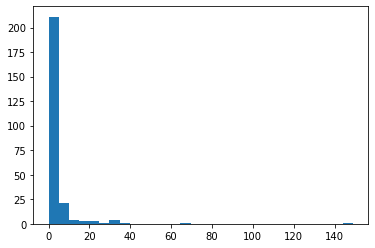

In [4]:
xf = fish_data.drop('FISH_COUNT',axis=1)
yf = fish_data['FISH_COUNT']

plt.hist(yf, bins=30);

**Here we see the distribution of the fishing data highlighting that it has a mass at zero and is discrete.**

In [5]:
(yf == 0).sum() / len(yf)

0.568

The data is about 56.8% 0.

**We must scale the exogenous variables (all others but y) to get an accurate assessment.**

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X = xf.copy() #ss.fit_transform(xf) #x.values
y = yf.values.reshape(-1,1)

xfs = pd.DataFrame(X, columns=xf.columns, index=xf.index)

xf.describe()

LIVE_BAIT      CAMPER    PERSONS    CHILDREN
count  250.000000  250.000000  250.00000  250.000000
mean     0.864000    0.588000    2.52800    0.684000
std      0.343476    0.493182    1.11273    0.850315
min      0.000000    0.000000    1.00000    0.000000
25%      1.000000    0.000000    2.00000    0.000000
50%      1.000000    1.000000    2.00000    0.000000
75%      1.000000    1.000000    4.00000    1.000000
max      1.000000    1.000000    4.00000    3.000000

### My Model

In [7]:
cwd = os.getcwd()
print(cwd)

C:\Users\schillw\OneDrive - FNBCorp\CECL 2020-2021\tweedie_huber_info_v2


In [8]:
# os.chdir('../ElasticNet')

from fnbbase.models import TweedieElasticNet as tweenet
from fnbbase.models import CrossValidation as cval
from fnbbase.models import ElasticNetUtils as utils

# os.chdir(cwd)

https://en.wikipedia.org/wiki/Tweedie_distribution


The Tweedie distributions include a number of familiar distributions as well as some unusual ones, each being specified by the domain of the index parameter. We have the

- extreme stable distribution, p < 0,
- normal distribution, p = 0,
- Poisson distribution, p = 1,
- compound Poisson–gamma distribution, 1 < p < 2,
- gamma distribution, p = 2,
- positive stable distributions, 2 < p < 3,
- Inverse Gaussian distribution, p = 3,
- positive stable distributions, p > 3, and
- extreme stable distributions, p = ∞.


For 0 < p < 1 no Tweedie model exists. Note that all stable distributions mean actually generated by stable distributions.

## TESTS

We will test the Tweedie model and compare results to statsmodels estimators for a few different powers. Additionally we will set the $\alpha$ parameter to a full Lasso and go to the minimum $\lambda$ depth for the "full solution".

### p == 1.0

divide by zero encountered in log
invalid value encountered in multiply


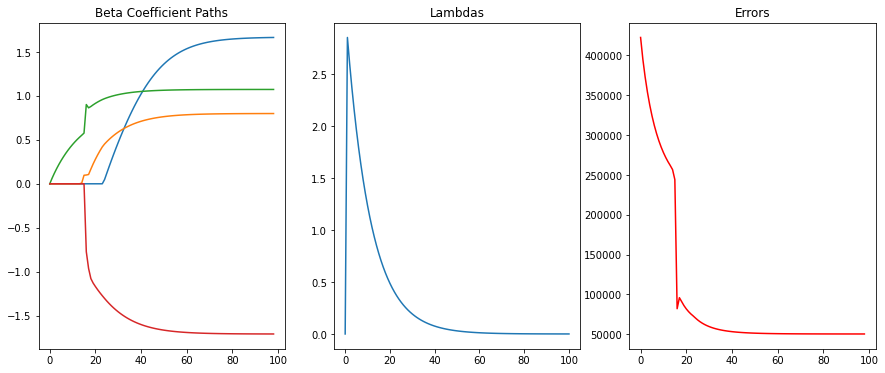

In [9]:
power = 1.0

model = tweenet.TweedieRegressor(power=power, alpha=1.0, depth=99, link='log', tol=1e-12)

model.fit(xfs, y, weights=1)

fig, ax=plt.subplots(1,3,figsize=(15,6))
ax[0].plot(model.B.T)
ax[0].set_title("Beta Coefficient Paths")
ax[1].plot(model.lambdas)
ax[1].set_title("Lambdas")
ax[2].plot(model.model_errors, color='r')
ax[2].set_title("Errors");

In [10]:
## statsmodels comparison
twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=power, eql=True))
tfit = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
tpred = tfit.predict()

my_model = pd.DataFrame(np.append(model.B0[:,-1], model.B[:,-1], 0), index=['const']+list(xfs.columns))
param_compare = pd.concat([my_model, tfit.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['abs diff'] = np.fabs(param_compare.statsmodels - param_compare.my_model)

print("mean tweedie deviance = {:5f}".format(mean_tweedie_deviance(tpred, model.predict())))
print("mean absolute error = {:5f}".format(mean_absolute_error(tpred, model.predict())))

param_compare

mean tweedie deviance = 0.000008
mean absolute error = 0.001196


divide by zero encountered in log
invalid value encountered in multiply


my_model  statsmodels  abs diff
const     -3.385461    -3.390075  0.004614
LIVE_BAIT  1.665564     1.669672  0.004108
CAMPER     0.799673     0.800093  0.000420
PERSONS    1.073852     1.073956  0.000104
CHILDREN  -1.709416    -1.709933  0.000517

**The difference in variables is small and the error between predictions is also small.**

In [11]:
disp_est = tfit.deviance/tfit.df_resid
print("Dispersion Estimate = {}".format(disp_est))

phi = tfit.deviance/tfit.model.iweights.sum()
print("Dispersion Estiamte 2 = {}".format(phi))

etp = twd.estimate_tweedie_power(tpred, low=1.01, high=1.99)
print("Estimated Tweedie Power = {}".format(etp))

pearson_disp_est = tfit.pearson_chi2/tfit.df_resid
tfit.deviance/np.sum(tfit.model.weights)

Dispersion Estimate = 5.0893467995840025
Dispersion Estiamte 2 = 4.987559863592322
Estimated Tweedie Power = 1.5472338352032016


divide by zero encountered in log
invalid value encountered in multiply


1.513215978031656

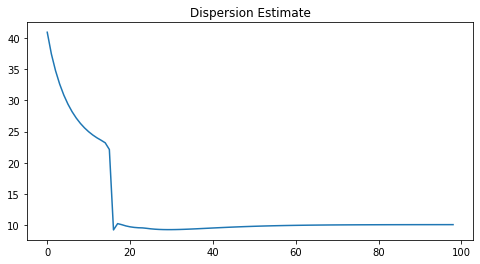

In [12]:
fig, ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(model.K.flatten());
ax.set_title("Dispersion Estimate");

### p == 1.5

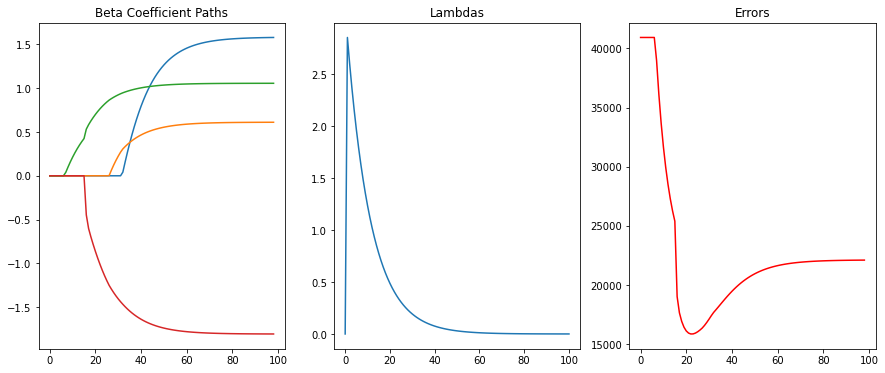

In [13]:
power = 1.5

model = tweenet.TweedieRegressor(power=power, alpha=1.0, depth=99, link='log', tol=1e-12)

model.fit(xfs, y, weights=1)

fig, ax=plt.subplots(1,3,figsize=(15,6))
ax[0].plot(model.B.T)
ax[0].set_title("Beta Coefficient Paths")
ax[1].plot(model.lambdas)
ax[1].set_title("Lambdas")
ax[2].plot(model.model_errors, color='r')
ax[2].set_title("Errors");

In [14]:
## statsmodels comparison
twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=power, eql=True))
tfit = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
tpred = tfit.predict()

my_model = pd.DataFrame(np.append(model.B0[:,-1], model.B[:,-1], 0), index=['const']+list(xfs.columns))
param_compare = pd.concat([my_model, tfit.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['abs diff'] = np.fabs(param_compare.statsmodels - param_compare.my_model)

print("mean tweedie deviance = {:5f}".format(mean_tweedie_deviance(tpred, model.predict())))
print("mean absolute error = {:5f}".format(mean_absolute_error(tpred, model.predict())))

param_compare

mean tweedie deviance = 0.000043
mean absolute error = 0.002433


my_model  statsmodels  abs diff
const     -3.077468    -3.081747  0.004278
LIVE_BAIT  1.579832     1.583495  0.003663
CAMPER     0.611346     0.611998  0.000652
PERSONS    1.056449     1.056687  0.000238
CHILDREN  -1.806867    -1.807657  0.000790

**The difference between models is slightly larger but this may not work best with this power.**

In [15]:
disp_est = tfit.deviance/tfit.df_resid
print("Dispersion Estimate = {}".format(disp_est))

phi = tfit.deviance/tfit.model.iweights.sum()
print("Dispersion Estiamte 2 = {}".format(phi))

etp = twd.estimate_tweedie_power(tpred, low=1.01, high=1.99)
print("Estimated Tweedie Power = {}".format(etp))

pearson_disp_est = tfit.pearson_chi2/tfit.df_resid
tfit.deviance/np.sum(tfit.model.weights)

Dispersion Estimate = 3.5063489349008354
Dispersion Estiamte 2 = 3.4362219562028185
Estimated Tweedie Power = 1.630742735857428


2.491400265411451

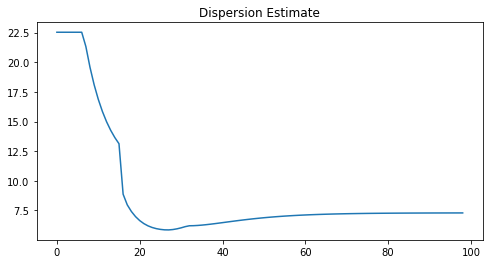

In [16]:
fig, ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(model.K.flatten());
ax.set_title("Dispersion Estimate");

### p == 1.99999

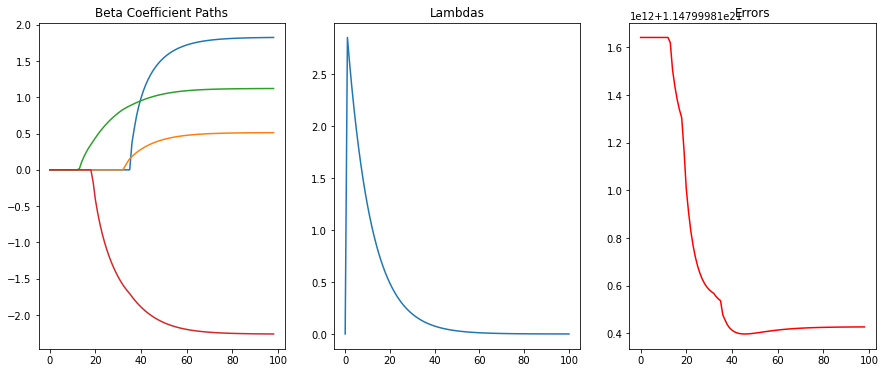

In [17]:
power = 1.999999999

model = tweenet.TweedieRegressor(power=power, alpha=1.0, depth=99, link='log', tol=1e-12)

model.fit(xfs, y, weights=1)

fig, ax=plt.subplots(1,3,figsize=(15,6))
ax[0].plot(model.B.T)
ax[0].set_title("Beta Coefficient Paths")
ax[1].plot(model.lambdas)
ax[1].set_title("Lambdas")
ax[2].plot(model.model_errors, color='r')
ax[2].set_title("Errors");

In [18]:
## statsmodels comparison
twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=power, eql=True),
             ) #offset = np.ones(len(y)))
tfit = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
tpred = tfit.predict()

my_model = pd.DataFrame(np.append(model.B0[:,-1], model.B[:,-1], 0), index=['const']+list(xfs.columns))
param_compare = pd.concat([my_model, tfit.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['abs diff'] = np.fabs(param_compare.statsmodels - param_compare.my_model)

print("mean tweedie deviance = {:5f}".format(mean_tweedie_deviance(tpred, model.predict())))
print("mean absolute error = {:5f}".format(mean_absolute_error(tpred, model.predict())))

param_compare

mean tweedie deviance = 0.001074
mean absolute error = 0.010927


my_model  statsmodels  abs diff
const     -3.150031    -3.154368  0.004337
LIVE_BAIT  1.824332     1.827362  0.003031
CAMPER     0.512298     0.513415  0.001117
PERSONS    1.120634     1.121574  0.000940
CHILDREN  -2.262340    -2.264265  0.001924

In [19]:
disp_est = tfit.deviance/tfit.df_resid
print("Dispersion Estimate = {}".format(disp_est))

phi = tfit.deviance/tfit.model.iweights.sum()
print("Dispersion Estiamte 2 = {}".format(phi))

etp = twd.estimate_tweedie_power(tpred, low=1.01, high=1.99)
print("Estimated Tweedie Power = {}".format(etp))

pearson_disp_est = tfit.pearson_chi2/tfit.df_resid
tfit.deviance/np.sum(tfit.model.weights)

Dispersion Estimate = 1159183577.680525
Dispersion Estiamte 2 = 1135999906.1269145
Estimated Tweedie Power = 1.4594028097703506


1135999906.1122115

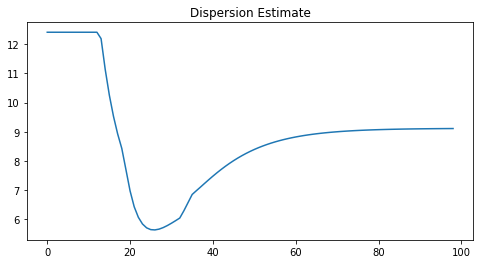

In [20]:
fig, ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(model.K.flatten());
ax.set_title("Dispersion Estimate");

### Comparison with SAS

link.power = 0 is the log link

**R Code:**

library(tweedie)
library(statmod)
library(lmtest)
library(sandwich)

df <- read.csv(data='data/fish.csv')
m1 <- glm(FISH_COUNT~., data=df, family=tweedie(var.power=1.4, link.power=0))
summary(m1)
coeftest(m1, vcov=vcovHC(m1, type='HC3'))
coeftest(m1, vcov=NeweyWest(m1, lag=12, prewhite=F))

In [81]:
sas_power = 1.4023

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=sas_power, eql=True),)
# tfit = twd.fit(cov_type='HAC', cov_kwds={'maxlags':12}, maxiter=1000, tol=1e-12)
# tpred = tfit.predict()

print("="*20," Normal Fit ","="*20)
tfit = twd.fit(maxiter=1000, tol=1e-12)
print(tfit.summary())

print("="*20," HC3 Fit ","="*20)
tfit = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(tfit.summary().tables[1])

print("="*20," HAC (NeweyWest) Fit ","="*20)
tfit = twd.fit(cov_type='HAC', cov_kwds={'maxlags':12}, maxiter=1000, tol=1e-12)
print(tfit.summary().tables[1])

====================  Normal Fit  ====================
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Tue, 02 Mar 2021   Deviance:                       841.62
Time:                        11:08:30   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

**when i added an offset of ones (len(y)), the const became -4.1148....**

In [78]:
tpred = tfit.predict()

### dispersion is scale???

- https://stats.stackexchange.com/questions/384521/in-glms-are-the-scale-and-dispersion-parameters-the-same
- https://www.sagepub.com/sites/default/files/upm-binaries/21121_Chapter_15.pdf

In [24]:
disp_est = tfit.deviance/(tfit.df_resid - tfit.df_model - 1)
print("Dispersion Estimate = {}".format(disp_est))

etp = twd.estimate_tweedie_power(tpred, low=1.01, high=1.99)
print("Estimated Tweedie Power = {}".format(etp))

pearson_disp_est = tfit.pearson_chi2/tfit.df_resid
pearson_disp_est, tfit.deviance/np.sum(tfit.model.weights)

Dispersion Estimate = 3.506753724211228
Estimated Tweedie Power = 1.6248889056738334


(7.640420898786343, 2.1448765374144187)

In [25]:
scale = np.sum((tfit.model.weights*tfit.resid_pearson**2)*(tfit.model.weights > 0))/tfit.df_resid
## i think it shold be var_weights not weights

print(tfit.model.scale, scale, np.sqrt(scale))

7.640420898786313 13.059050185852108 3.6137307849163456


In [26]:
np.sum((tfit.model.var_weights*tfit.resid_pearson**2)*(tfit.model.var_weights > 0))/tfit.df_resid

7.640420898786344

In [27]:
## chi2 square scale
resid = np.power(tfit.model.endog - tpred, 2) * tfit.model.iweights
np.sum(resid / tfit.family.variance(tpred)) / tfit.df_resid

7.640420898786343

In [28]:
tfit.params

const       -3.114770
LIVE_BAIT    1.581668
CAMPER       0.645414
PERSONS      1.056827
CHILDREN    -1.775259
dtype: float64

In [29]:
sas_genmod_disp = 1/(tfit.df_resid - tfit.df_model - 1) * \
                  np.sum((tfit.model.weights*tfit.resid_pearson**2)*(tfit.model.weights > 0))

print(sas_genmod_disp, np.sqrt(sas_genmod_disp), np.mean(y))

13.331113731390694 3.6511797725380073 3.296


In [30]:
# tfit.model.endog > 0

In [31]:
# tfit.model.var_weights
# mu = 
## this is estimate scale / dispersion?
twd.estimate_scale(tpred)


7.640420898786343

In [32]:
phi = tfit.deviance/tfit.model.iweights.sum()
print(phi)

3.366483575242779


In [33]:
prob_zero = np.exp(-tpred**(2-etp) / phi / (2-etp))
prob_zero[:10]

array([0.69354617, 0.43009124, 0.51564857, 0.52495907, 0.51564857,
       0.48111178, 0.47143576, 0.74446277, 0.76190004, 0.43009124])

- https://github.com/cran/tweedie/blob/master/R/tweedie.R
- CTRL F for "disp"

In [34]:
# tfit.deviance/tfit.model.freq_weights

In [35]:
# model.weights

### Compute Dispersion and Power

- https://gist.github.com/dantonnoriega/ad2081c39b26d0f523ba3464f4a90282

- use Pearson deviance method? 
- https://v8doc.sas.com/sashtml/stat/chap29/sect27.htm#:~:text=If%20you%20specify%20the%20SCALE,by%20its%20degrees%20of%20freedom.
    - If you specify the SCALE=DEVIANCE option, the dispersion parameter is estimated by the deviance divided by its degrees of freedom. 
    - If you specify the SCALE=PEARSON option, the dispersion parameter is estimated by Pearson's chi-square statistic divided by its degrees of freedom.

In [36]:
tfit.deviance

841.6208938106947

In [37]:
tfit.scale

7.640420898786313

In [38]:
tfit.pearson_chi2 / tfit.df_resid

7.640420898786343

- figure out how to calculate the scale
- then the dispersion (were close to SAS with the final model in CI MFG)
- then the power

## Optimizing the Power

In [39]:
## from sklearn.model_selection import GridSearchCV
##  cant use it since the estimator has a mismatch to sklearn

In [40]:
# emod = tweenet.TweedieRegressor(power=1.0, alpha=1.0, depth=99, link='log', tol=1e-12)
# gcv = GridSearchCV(emod, param_grid = {'power':[1.0, 1.5, 1.9]})

In [41]:
# gcv.fit(xfs, y)

In [42]:
## V(y) = mu^p --> p = log(mu)/log(y)
# var_y = y.var()
# p_est = np.log(y)/np.log(var_y)
# p_est

In [43]:
def tweedie_loglikelihood(y, yhat, p):
    loss = - y * np.power(yhat, 1-p) / (1-p) + np.power(yhat, 2-p) / (2-p)
    return np.mean(loss)

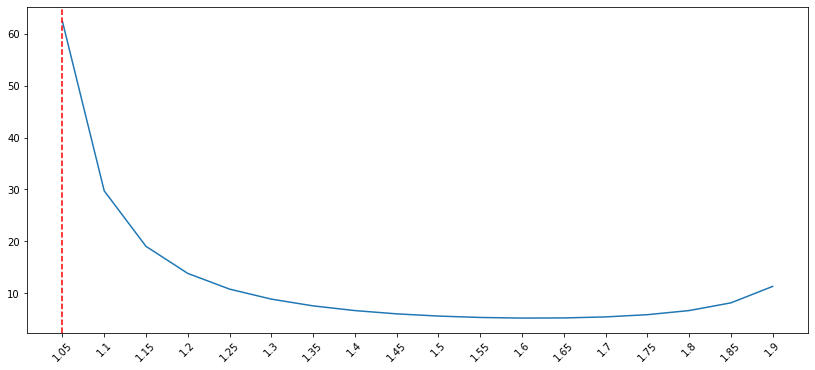

In [44]:
pwrs = np.arange(1.05,1.95,0.05)
llfs = []
for p in pwrs:
    llfs.append(tweedie_loglikelihood(y, model.predict(), p))
fig, ax=plt.subplots(1,1,figsize=(14,6))
ax.plot(llfs);
plt.xticks(range(len(pwrs)), labels=np.round(pwrs,2));
ax.axvline(np.argmax(llfs), c='r', ls='--');
ax.tick_params(axis='x', labelrotation=45)

In [45]:
scores = []
etps = []
sm_etps = []
## between 1 and 2
pwrs = np.arange(1.0, 2.0, 0.05)
for pwr in pwrs:
#     tmod = tweenet.TweedieRegressor(power=pwr, alpha=1.0, depth=99, link='log', tol=1e-12)
#     temp_fit = tmod.fit(xfs,y)
#     scores.append(tmod.score(xfs,y, score_method='loglike')[0])
    
    tglm = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=pwr, eql=True))
    tfit = tglm.fit()
    tpred = tfit.predict()
#     etps.append(tglm.estimate_tweedie_power(tpred, low=1.01, high=1.99)) ## this doesnt always work
    sm_etps.append(tglm.estimate_tweedie_power(tpred, low=1.01, high=10)) ## this doesnt always work
    etps.append(tfit.llf)

divide by zero encountered in log
invalid value encountered in multiply
divide by zero encountered in log
invalid value encountered in multiply


In [46]:
sm_etps

[1.5472338352032007,
 1.5597926261164803,
 1.5717990898079253,
 1.5831371538800683,
 1.5936758700415627,
 1.6032689123305808,
 1.6117539774600531,
 1.6189519087986863,
 1.624665293353063,
 1.6286762092060212,
 1.6307427358579738,
 1.6305937889739908,
 1.6279218169672538,
 1.6223729344586129,
 1.6135342702656466,
 1.6009189756616955,
 1.583951341238461,
 1.56196038580729,
 1.5342081595534323,
 1.5000357712953187]

In [47]:
etps

[nan,
 -583.3572268853267,
 -577.0457997371915,
 -571.4745342784553,
 -566.6300343614876,
 -562.5071040680684,
 -559.1115011377235,
 -556.4634918487488,
 -554.6027494817021,
 -553.5955340106659,
 -553.5458251122975,
 -554.613527601891,
 -557.0459122900418,
 -561.2353618614666,
 -567.8336603818916,
 -578.0009217593213,
 -594.0222372493535,
 -621.1434480785459,
 -674.8724485731129,
 -831.9116945576029]

In [48]:
np.argmax(etps)

0

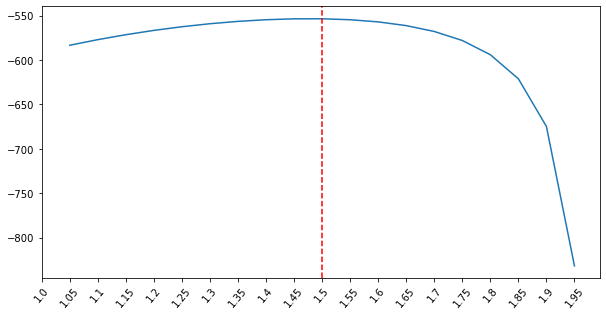

In [49]:
fig, ax=plt.subplots(1,1,figsize=(10,5))
# ax.plot(scores);
ax.plot(etps);
plt.xticks(range(len(pwrs)), labels=np.round(pwrs,2));
# ax.axvline(np.argmax(scores), c='r', ls='--');
ax.axvline(np.nanargmax(etps), c='r', ls='--');
ax.tick_params(axis='x', labelrotation=50)

**Follows the inverted U shape and according to our power optimization, we would have an optimal power at 1.4. Based on the built in statsmodels estimate_tweedie_power on each of the predictions, it shows we are somewhere between 1.5 and 1.6.**

## CrossValidation

**Please remember that this is a TIME SERIES SPECIFIC validator and not a K-FOLD validator which may be more appropriate here.**

In [50]:
# help(cval.FNBTimeSeriesSplit)
break

In [51]:
mod = tweenet.TweedieRegressor(power=1.4, alpha=0.99, depth=99, link='log', tol=1e-12)
tss = cval.FNBTimeSeriesSplit(n_splits=5, test_size=10)
cv = tweenet.TweedieCrossValidator(mod, tss)
cv.fit(xfs, y)

In [52]:
results = cv.cv_data_agg()

In [53]:
bcf, mean_coefs = cv.coefficient_frequency(param_names=xfs.columns)
bcf

variable value_sign  count    percent  cumulative_count  cumulative_percent
0   PERSONS        pos      5  45.454545                 5           45.454545
1  CHILDREN        neg      5  45.454545                10           90.909091
2    CAMPER        pos      1   9.090909                11          100.000000

**In this instance we see that the variables PERSONS and CHILDREN were significant in all 5 CVs.**

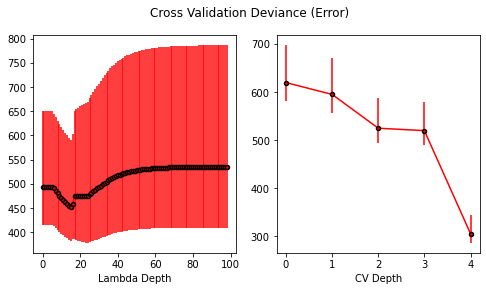

In [54]:
utils.err_plot(cv.mod_err, figsize=(8,4))

The error plots show:
- For the lambda depth plot, each black dot represents the error at each lambda depth and the red error bars represent the variance over each cross validation at that depth.

- For the CV depth plot, each black dot represents the error at each CV and the red error bars represent the variance over each lambda at that depth.

In the fit methods of the CVs and models there is a quick variable finding and setting the minimum error of that fit and those variables are chosen there and the values are set. In the charts above these get defined as showing our minimum error across the lambdas was at 0 (sparse model) and at the first CV.

### Distribution Generation

- https://appliedmachinelearning.blog/2018/08/31/lets-talk-about-numeric-distributions-python/

In [55]:
def tweedie(n,p,mu,phi):
    np.random.seed(seed=32)
    #checking the value of variance power between 1-2
    if (p==2):
        print('p must be between (1,2)')
        pass
    else:
        rt=np.full(n,np.nan)
    # calculating mean of poisson distribution
        lambdaa=mu**(2-p)/(phi*(2-p))
    # shape parameter of gamma distribution
        alpha=(2-p)/(1-p)
    # scale parameter of gamma distribution
        gam= phi*(p-1)*(mu**(p-1))
    # Generating Poisson random sample
        N=np.random.poisson(lambdaa,n)
        for i in range(n):
        # Generate single data point of gamma distribution using poisson random variable
            rt[i]=np.random.gamma(N[i]*np.abs(alpha),gam,1)
        return(rt)

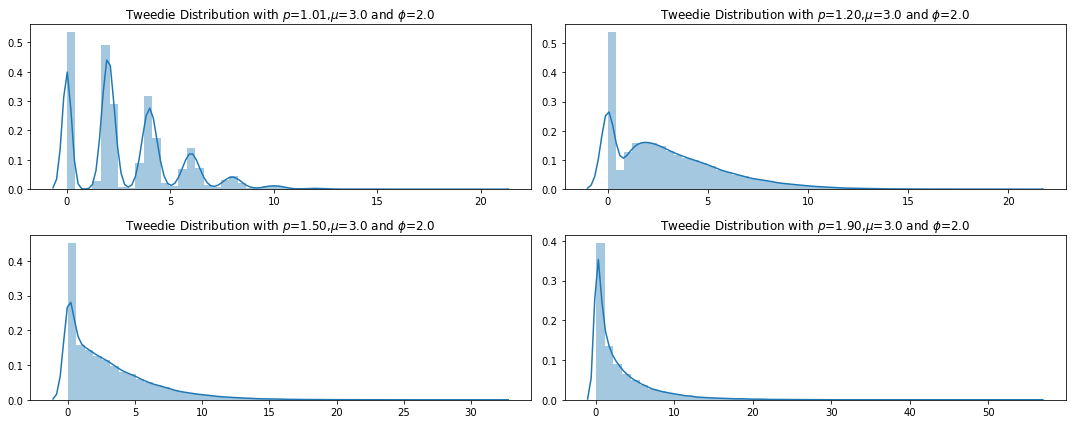

In [56]:
vals=[1.01,1.2,1.5,1.9]
fig, axes =plt.subplots(2,2, figsize=(15,6))
axes=axes.flatten()
for ax,i in zip(axes,vals):
    s_tweedie=tweedie(50000,i,3,2)
    titles = 'Tweedie Distribution with $p$=%.2f,$\mu$=%.1f and $\phi$=%.1f'%(i,3,2)
    sns.distplot(pd.DataFrame(s_tweedie),ax=ax).set_title(titles)
plt.tight_layout()
plt.show()

### Dispersion Calcs??

- https://en.wikipedia.org/wiki/Compound_Poisson_distribution

In [57]:
def disp_est(self, X, y, b0, b, offset=1, k=1):
    '''Dispersion Estimate for NegBinRegressor'''
    iters, k0 = 0, 0
    while np.abs(k-k0) > 1e-3:
        k0 = np.copy(k)
        k = k - 0.01/np.sqrt(len(X)+iters) * self.local_grad(X,y,b0,b,offset,k)
        iters += 1 ## this is mainly for error checking
        if k<0:
            k = 1e-6
            break
    return k, iters

def local_grad(self, X, y, b0, b, offset=1, k=1):
    '''NegBinRegressor Gradient Calculation'''
    mu = np.exp(b0 + X.dot(b) + np.log(offset))
    g1 = psi(y+1/k)*(-1/k**2) + psi(1/k)*(1/k**2) + (1/k**2)*np.log(k) - (1/k**2)
    g2 =  (1/k**2)*np.log(1/k + mu) + (1/k**3)/(1/k + mu) + (y/(1/k + mu))*(1/k**2)
    return -np.sum(g1 + g2)

In [58]:
sig = 1

lam = mu**(2-p)/(sig**2 * (2-p))
alpha = (2-p)/(p-1)
# gam = phi*(p-1)*(mu**(p-1))
beta = mu**(1-p)/((p-1)*sig**2)



NameError: name 'mu' is not defined